# Beyond

#### Σε αυτό το τετράδιο γίνεται μια προσπάθεια να αυξηθεί η απόδοση του μοντέλου. Ωστόσο, __ξεκινάμε από__ την αρχή καθώς υπάρχουν σημεία ακόμα και στην __προεπεξεργασία των δεδομένων__  που θα πρέπει να αλλάξουν.

#### Σε αυτό το τετράδιο, θα χρησιμοποιήσουμε __matplotlib__. Για το fine tuning της συγκεκριμένης βιβλιοθήκης, γράφουμε αρχικά τον παρακάτω κώδικα.

In [1]:
# reload modules before executing user code

In [2]:
%load_ext autoreload

In [3]:
# initialize matplotlib environment

In [4]:
%autoreload 2

In [5]:
%matplotlib inline

#### Είμαστε έτοιμοι να __εισάγουμε__ τις __βιβλιοθήκες__ στο πρόγραμμά μας.

In [6]:
import io
import os
import math
import copy
import numpy
import torch
import pandas
import pickle
import zipfile
import itertools
import matplotlib.pyplot
import sklearn.model_selection
import sklearn.decomposition

#### Ορίζουμε το μοντέλο μας. Το προχωρημένο μοντέλο αποτελείται από __3 κρυφά επίπεδα τύπου Embedding__ για να γίνει το __matrix factorization__.

In [7]:
# model class for matrix factorization
class EmbeddingNet(torch.nn.Module):

    def __init__(self, n_users, n_movies, n_factors=50, embedding_dropout=0.02, hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):

            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in itertools.zip_longest(hidden, dropouts):
                yield torch.nn.Linear(n_in, n_out)
                yield torch.nn.ReLU()
                if rate is not None and rate > 0.:
                    yield torch.nn.Dropout(rate)
                n_in = n_out
            
        self.u = torch.nn.Embedding(n_users, n_factors)
        self.m = torch.nn.Embedding(n_movies, n_factors)
        self.drop = torch.nn.Dropout(embedding_dropout)
        self.hidden = torch.nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = torch.nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        def init(m):
            if type(m) == torch.nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)

#### Αυτή η κλάση βοηθάει στην __προσπέλαση__ του εκάστοτε __batch__.

In [8]:
# batch iterator class
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = numpy.asarray(X), numpy.asarray(y)
        
        if shuffle:
            index = numpy.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

#### Παρακάτω ορίζουμε μια κλάση __βελτίωσης__ (optimization) ως προς την __απόδοση του νευρωνικού δικτύου__. Η τεχνική που προγραμματίζεται είναι το __Cyclic LR__, το οποίο το προγραμματίζουμε χρησιμοποιώντας πάλι το framework __Pytorch__.

In [9]:
# scheduler class
class CyclicLR(torch.optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

#### Ορίζουμε μια συνάρτηση για την αρχικοποίηση του αλγορίθμου επιλογής __τυχαίας ακολουθίας__ των __numpy__ και __torch__ βιβλιοθηκών.

In [10]:
# common randomizer function
def set_random_seed(state=1):
    gens = (numpy.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

#### Ορίζουμε μια συνάρτηση για την __εισαγωγή των δεδομένων__ μας από τον υπολογιστή.

In [11]:
# function defined to import data from system
def read_data(path):
    files = {}
    for filename in os.listdir(path):
        stem, suffix =  os.path.splitext(filename)
        file_path = os.path.join(path,filename)
        if suffix == '.data':
            if stem == 'u':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            data = pandas.read_csv(file_path, sep='\t', names=columns, engine='python')
            files[stem] = data
    return files['u']

#### Ορίζουμε μια συνάρτηση που θα επιστρέψει το __συμβατό με το Pytorch dataset__.

In [12]:
# Pytorch compatible dataset creator function
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pandas.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(numpy.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

#### Παρακάτω ορίζουμε μια συνάρτηση που καλεί την κλάση __ReviewsIterator__ και επιστρέφει τα ζητούμενα __batches__.

In [13]:
# function that uses ReviewsIterator class to return batches
def batches(X, y, bs=16, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

#### Στην κλάση του μοντέλου κάποια στιγμή καλείται να __μετατρέψει σε λίστα__ κάποιες μεταβλητές. Παρακάτω ορίζουμε την συνάρτηση που καλείται για αυτόν το σκοπό. 

In [14]:
# function used by model's class: converts hidden and dropout parameters to list
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

#### Ορίζουμε μια __συνάρτηση συνημιτόνου__ που θα κληθεί από την κλαση __CyclicLR__.

In [15]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

#### Ορίζουμε μια συνάρτηση για το __plotting__.

In [16]:
# custom plot function
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    matplotlib.pyplot.plot(ts, y)

#### Ορίζουμε μια συνάρτηση για τη __μετατροπή ενός torch tensor σε numpy array__.

In [17]:
# tensor to numpy transormation function
def to_numpy(tensor):
    return tensor.cpu().numpy()

#### Ορίζουμε το style που θα χρησιμοποιήσει η βιβλιοθήκη matplotlib.

In [18]:
# set plot style
matplotlib.pyplot.style.use('ggplot')

#### Αρχικοποιούμε με κοινό τρόπο τις τυχαίες ακολουθίες.

In [19]:
# initialize randomizer
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

#### Φορτώνουμε τα δεδομένα μας. Παρακάτω έχει χρησιμοποιηθεί __absolute path__, το οποίο θα πρέπει να αντικατασταθεί από το path του directory που περιέχει το αρχείο "u.data".

In [20]:
# load file
ratings = read_data('/home/andreas/Documents/deepLearning/ml-100k/')

#### Παρακάτω δημιουργούμε το dataset που θα χειριστούμε αργότερα.

In [21]:
# define dataset
(n, m), (X, y), _ = create_dataset(ratings)

In [22]:
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 943 users, 1682 movies
Dataset shape: (100000, 2)
Target shape: (100000,)


In [23]:
X['user_id'].min()

0

In [24]:
X['user_id'].max()

942

In [25]:
X['movie_id'].min()

0

In [26]:
X['movie_id'].max()

1681

#### Είμαστε έτοιμοι να __ορίσουμε το μοντέλο μας__.

In [27]:
# define neural network
net = EmbeddingNet(n_users=n, n_movies=m, n_factors=150, hidden=[500, 500, 500], embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

#### Ορίζουμε τα __training__ και __validation datasets__.

In [28]:
# split dataset into training set and test set
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [29]:
# find minimum and maximum integers in ratings 
minmax = ratings.rating.min(), ratings.rating.max()
minmax

(1, 5)

#### Παρακάτω ορίζουμε σημαντικές __παραμέτρους και υπερπαραμέτρους__ του μοντέλου.

In [30]:
# important model parameters
learning_rate = 1e-4
weight_decay = 1e-5
batch_size = 16 
n_epochs = 200
no_improvements = 0
best_loss = numpy.inf
best_weights = None
history = []
learning_history = []

#### Παρακάτω ορίζουμε το threshold του __early stopping__.

In [31]:
# patience variable: variable used for early stopping
# if there are ${patience} consecutive epochs where validation loss was worse compared to previous epoch's validation loss, then call early stopping 
patience = 3

#### Όπως και στο δεύτερο τετράδιο, αν υπάρχει __διαθέσιμη κάρτα γραφικών NVIDIA__, τότε ορίζεται ως προεπιλεγμένη συσκευή __για τους υπολογισμούς του Pytorch__, λόγω αυξημένης ταχύτητας.

In [32]:
# check hardware if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
# send model to GPU if available
net.to(device)

EmbeddingNet(
  (u): Embedding(943, 150)
  (m): Embedding(1682, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

#### Παρακάτω ορίζονται κάποιες ακόμα υπερπαράμετροι του μοντέλου.

In [34]:
# more model parameters
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // batch_size))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=learning_rate/10))

#### Είμαστε έτοιμοι να αρχίσουμε την __εκπαίδευση του μοντέλου__.

In [35]:
# fit model
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    # separate training and validation phases
    for phase in ('train', 'val'):
        training = phase == 'train'
        
        running_loss = 0.0
        n_batches = 0
        batch_num = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=batch_size):
            # part of code used in both training and validation phases of model
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # part of code used only while in training mode
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)

                if training:                   
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    learning_history.extend(scheduler.get_lr())
            # keep record of each epoch's prediction errors
            running_loss += loss.item()
        
        # calculate epoch loss    
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # define early stopping conditionals
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                # save weights of the best model so far
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    # keep history record            
    history.append(stats)
    # print epoch's stats
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    # check early stopping conditionals
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/200] train: 1.0090 - val: 0.9037
loss improvement on epoch: 2
[002/200] train: 0.8767 - val: 0.8914
loss improvement on epoch: 3
[003/200] train: 0.8807 - val: 0.8815
loss improvement on epoch: 4
[004/200] train: 0.8365 - val: 0.8782
[005/200] train: 0.8491 - val: 0.8782
loss improvement on epoch: 6
[006/200] train: 0.8141 - val: 0.8781
loss improvement on epoch: 7
[007/200] train: 0.8301 - val: 0.8767
[008/200] train: 0.7947 - val: 0.8792
loss improvement on epoch: 9
[009/200] train: 0.8073 - val: 0.8758
[010/200] train: 0.7695 - val: 0.8854
[011/200] train: 0.7799 - val: 0.8804
[012/200] train: 0.7287 - val: 0.8879
early stopping after epoch 012


#### Παρακάτω κάνουμε __plot__ τα σχετικά __errors της εκπαίδευσης__.

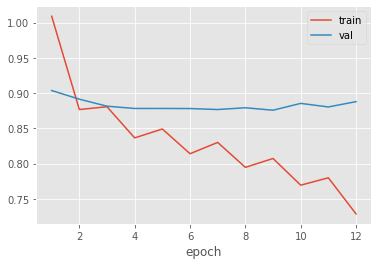

In [36]:
# plot model's train and validation history 
ax = pandas.DataFrame(history).drop(columns='total').plot(x='epoch')

#### Παρακάτω κάνουμε ένα __test με ανακατεμμένο το dataset__ και βλέπουμε τα αποτελέσματα.

In [37]:
# initialize lists for testing
groud_truth, predictions = [], []

In [38]:
# test model using test set
with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=batch_size):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

In [39]:
# predictions and actual ratings as numpy arrays
groud_truth = numpy.asarray(groud_truth).ravel()
predictions = numpy.asarray(predictions).ravel()
numpy.array(predictions)

array([4.30248547, 3.97883844, 4.06457424, ..., 3.46837997, 1.78524947,
       4.43330622])

In [40]:
# RMSE of model
final_loss = numpy.sqrt(numpy.mean((numpy.array(predictions) - numpy.array(groud_truth))**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.9420


#### Παρακάτω γράφουμε την εντολή που θα καλέσει __το μοντέλο να κάνει μια πρόβλεψη__.

In [41]:
# how to call model to predict
prediction = net(torch.tensor(X['user_id'].values).to(device), torch.tensor(X['movie_id'].values).to(device), minmax)

#### Αποθηκεύουμε τα βάρη του μοντέλου μας.

In [42]:
# save model's weights
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

#### Επαναφορτώνουμε το μοντέλο μας.

In [43]:
# reload model
with open('best.weights', 'rb') as file:
    best_weights = pickle.load(file)

In [44]:
# check successful sync
net.load_state_dict(best_weights)

<All keys matched successfully>

#### Για τη βελτίωση απόδοσης δεσμευμένου __χώρου του μοντέλου__, παρακάτω κάνουμε __PCA__.

In [45]:
# dimentionality reduction using Principal Component Analysis
_, _, (user_id_map, movie_id_map) = create_dataset(ratings)
embed_to_original = {v: k for k, v in movie_id_map.items()}
popular_movies = ratings.groupby('movieId').movieId.count().sort_values(ascending=False).values[:1000]
embed = to_numpy(net.m.weight.data)
pca = sklearn.decomposition.PCA(n_components=5)
components = pca.fit(embed[popular_movies].T).components_
components.shape

(5, 1000)